## Merge the similarity graphs and exploitation of the weight matrix##

Attribute a new number to each new genre and replace in the dataframe

In [48]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
from imdb import IMDb
import tmdbsimple as tmdb
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

In [49]:
dfGenre = pd.read_csv('Saved_Datasets/NormalizedGenreWSparse.csv', encoding = 'latin-1')
dfActor = pd.read_csv('Saved_Datasets/NormalizedActorW.csv', encoding = 'latin-1')
dfDirector = pd.read_csv('Saved_Datasets/NormalizedDirectorW.csv', encoding = 'latin-1')
dfText = pd.read_csv('Saved_Datasets/NormalizedTextW.csv', encoding = 'latin-1')
dfTenures = pd.read_csv('Saved_Datasets/NormSparsActTenuresW.csv', encoding = 'latin-1')
dfProd = pd.read_csv('Saved_Datasets/NormalizedCompaniesW.csv', encoding = 'latin-1')

In [50]:
print('There are {} movies in dfGenre'.format(len(dfGenre)))
print('There are {} movies in dfActor'.format(len(dfActor)))
print('There are {} movies in dfDirector'.format(len(dfDirector)))
print('There are {} movies in dfText'.format(len(dfText)))
print('There are {} movies in dfTenures'.format(len(dfTenures)))
print('There are {} movies in dfProd'.format(len(dfProd)))

There are 2621 movies in dfGenre
There are 2621 movies in dfActor
There are 2621 movies in dfDirector
There are 2621 movies in dfText
There are 2621 movies in dfTenures
There are 2621 movies in dfProd


In [51]:
dfActor.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.1 Addition the weight matrices ###

Import the dataframes as matrices and addition them to form the total weight matrix.

In [52]:
WGenre = dfGenre.as_matrix(columns=None)
WActors = dfActor.as_matrix(columns=None)
WDirectors = dfDirector.as_matrix(columns=None)
WText = dfText.as_matrix(columns=None)
WTenures = dfTenures.as_matrix(columns=None)
WProd = dfProd.as_matrix(columns=None)

WTot = (WGenre + WActors + WDirectors + WText + WTenures + WProd)/6

Check that the size is correct

In [53]:
print(WTot.shape)

(2621, 2621)


#### Save the dataset ####

In [54]:
NormW = pd.DataFrame(WTot)
NormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.000000,0.000000,0.000000,0.000000,0.156239,0.182031,0.166473,0.000000,0.041667,0.041667,...,0.033333,0.000000,0.000000,0.041667,0.164661,0.148890,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.027778,0.166634,0.027778,0.027778,0.150210,0.000000,0.166028,0.000000,...,0.163853,0.154253,0.000000,0.166427,0.134061,0.191401,0.000000,0.033333,0.159733,0.310120
2,0.000000,0.027778,0.000000,0.163698,0.156541,0.186122,0.000000,0.000000,0.598772,0.000000,...,0.175593,0.163864,0.000000,0.164661,0.000000,0.165545,0.000000,0.200433,0.193882,0.194251
3,0.000000,0.166634,0.163698,0.000000,0.000000,0.000000,0.000000,0.161453,0.000000,0.165438,...,0.000000,0.000000,0.166427,0.000000,0.000000,0.000000,0.166650,0.000000,0.000000,0.000000
4,0.156239,0.027778,0.156541,0.000000,0.000000,0.000000,0.000000,0.166028,0.000000,0.159984,...,0.177615,0.027778,0.000000,0.000000,0.000000,0.000000,0.164798,0.152468,0.000000,0.148890


In [55]:
NormW.to_csv('Saved_Datasets/NormalizedTotW.csv', index=False)

### 1.2 Determine properties of the graph ### 

Visualize the graph

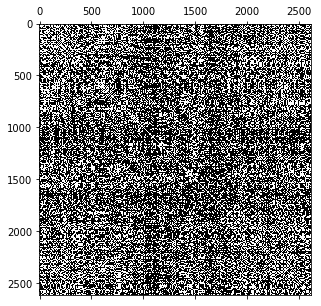

In [56]:
plt.spy(WTot)

Plot a histogram of the weights

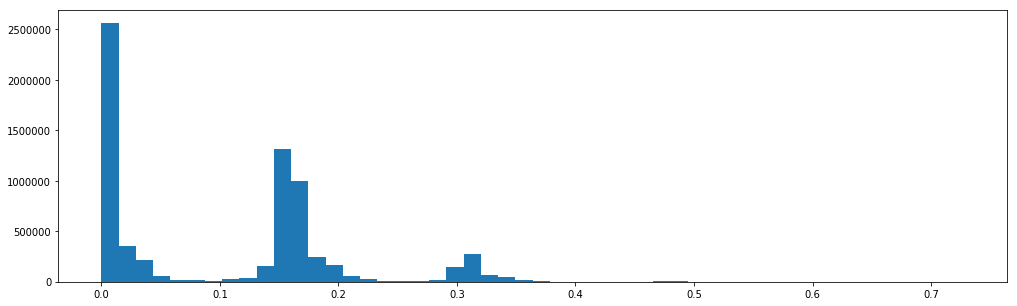

In [57]:
plt.hist(WTot.reshape(-1), bins=50);

In [58]:
print('The mean value is: {}'.format(WTot.mean()))
print('The max value is: {}'.format(WTot.max()))
print('The min value is: {}'.format(WTot.min()))

The mean value is: 0.10238289242738909
The max value is: 0.7275148979200173
The min value is: 0.0


In [59]:
sum(sum(WTot > 0.5))/2

949.0

### Test sparsify ###

Change type of following cell and uncomment for sparsification

NEIGHBORS = 300

#sort the order of the weights
sort_order = np.argsort(WTot, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(WTot), len(WTot)))

for i in range (0, len(WTot)):  
    for j in range(0, len(WTot)):
        if (j >= len(WTot) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = WTot[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

In [60]:
#WTot = sorted_weights

In [61]:
#plt.spy(WTot)

In [62]:
#plt.hist(WTot.reshape(-1), bins=50);

#### 1.2.1 Plot the degree distribution ###

In [63]:
print(WTot[1])
print(len(WTot[1]))
print(sum(WTot[1]))

[ 0.          0.          0.02777778 ...,  0.03333333  0.15973309
  0.31012013]
2621
223.989666786


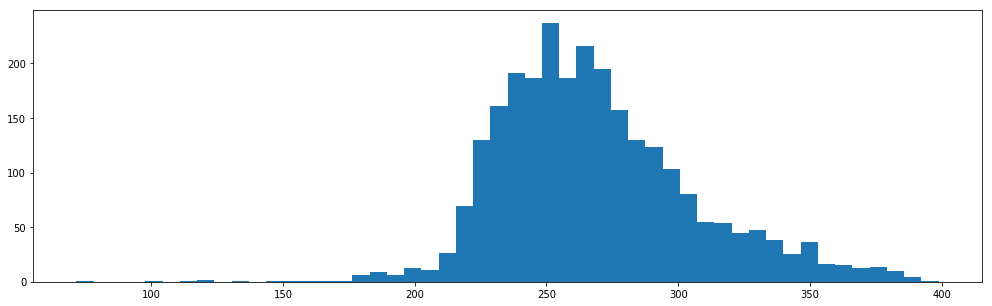

In [64]:
degrees = np.zeros(len(WTot)) 

#reminder: the degrees of a node for a weighted graph are the sum of its weights

for i in range(0, len(WTot)):
    degrees[i] = sum(WTot[i])

plt.hist(degrees, bins=50);

In [65]:
print('The mean value is: {}'.format(degrees.mean()))
print('The max value is: {}'.format(degrees.max()))
print('The min value is: {}'.format(degrees.min()))

The mean value is: 268.3455610521847
The max value is: 398.8272918701097
The min value is: 71.62164228892706


### 2 Graph Laplacian ### 

Computation of the graph Laplacian and its normalized value.

#### 2.1 Traditional method ###

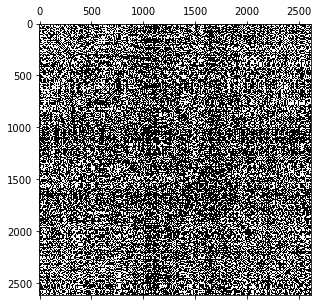

In [66]:
#reminder: L = D - W for weighted graphs
laplacian = np.diag(degrees) - WTot 

#computation of the normalized Laplacian
laplacian_norm = scipy.sparse.csgraph.laplacian(WTot, normed = True)

plt.spy(laplacian_norm);

In [67]:
laplacian_norm = sparse.csr_matrix(laplacian_norm)

In [68]:
eigenvalues, eigenvectors =  sparse.linalg.eigsh(laplacian_norm, k = 10, which = 'SM') 

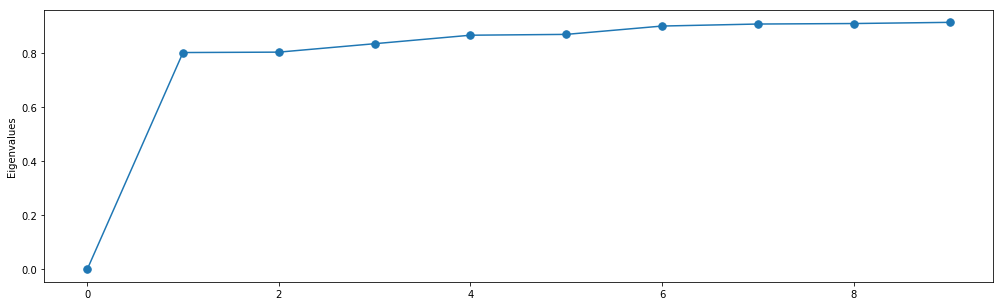

In [69]:
plt.plot(eigenvalues, '.-', markersize=15);
plt.xlabel('')
plt.ylabel('Eigenvalues')
plt.show()

In [70]:
print(np.diag(degrees).shape)

(2621, 2621)


In [71]:
print(WTot.shape)

(2621, 2621)


In [72]:
print(laplacian.shape)

(2621, 2621)


#### 2.2 Graph method ####

In [73]:
G = graphs.Graph(WTot)

In [74]:
G.compute_laplacian('normalized')

In [75]:
#plt.spy(G.L)

### 3. Fourier basis ####

In [76]:
G.compute_fourier_basis(recompute=True)

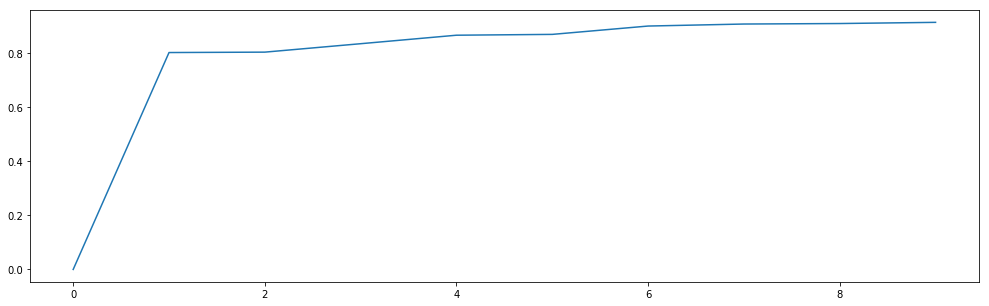

In [77]:
plt.plot(G.e[0:10]);

### 4. PCA and Graph embedding ###

In [78]:
dfNewFeats = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [79]:
len(dfNewFeats)

2621

In [80]:
dfNewFeats.head()

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,tagline,title,director_name,director_id,actor_names,actor_ids,Metacritic,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,Andrew Stanton,0,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...","[0, 908, 2000, 772, 3304]",90,9.003570,1
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,You don't need eyes to see.,Dancer in the Dark,Lars von Trier,1,"['Björk', 'Catherine Deneuve', 'David Morse', ...","[1, 434, 2001, 1630, 3993]",61,2.127491,1
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,2,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...","[2, 412, 136, 71, 3143]",63,3.678652,1
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Go for the kill.,Kill Bill: Vol. 1,Quentin Tarantino,3,"['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...","[3, 1071, 2002, 1684, 1097]",69,5.031633,1
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Welcome to the suck.,Jarhead,Sam Mendes,4,"['Jamie Foxx', 'Scott MacDonald', 'Lucas Black...","[4, 1072, 328, 1293]",58,0.345694,1


#### 4.1 Graph embedding ####

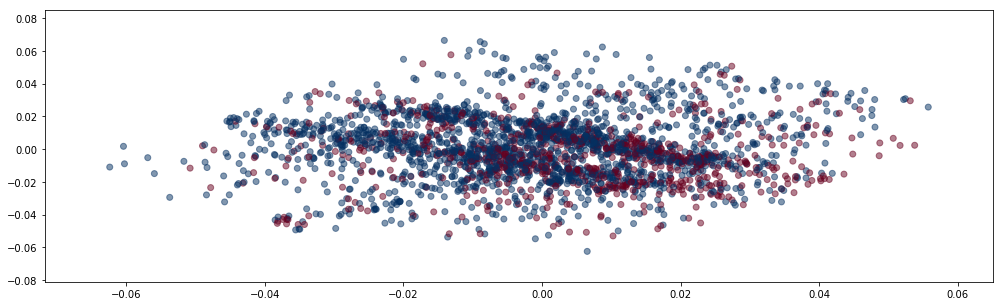

In [81]:
genres = preprocessing.LabelEncoder().fit_transform(dfNewFeats['success'])

x = eigenvectors[:, 1] 
y = eigenvectors[:, 2] 
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

In [82]:
len(dfNewFeats[dfNewFeats['success'] == 0])

796

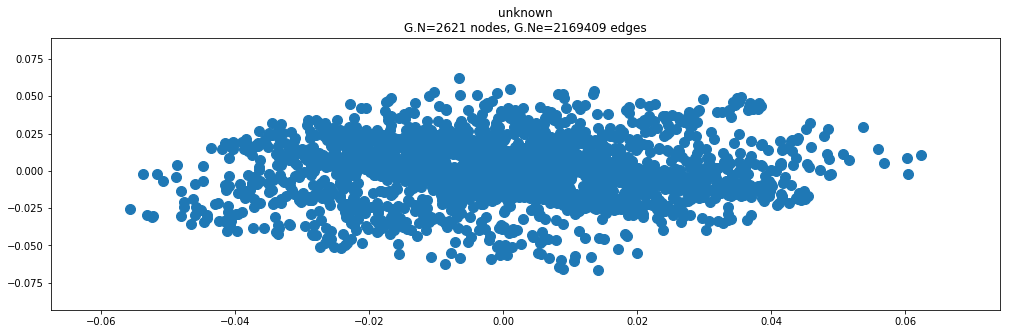

In [83]:
#Note: eigenvalues and their respective eigenvectors are already sorted from smallest to biggest

#plot on the eigenvectors 2 and 3 (set_coordinates takes Nx2 or Nx3 array size)
G.set_coordinates(G.U[:,1:3])
G.plot()

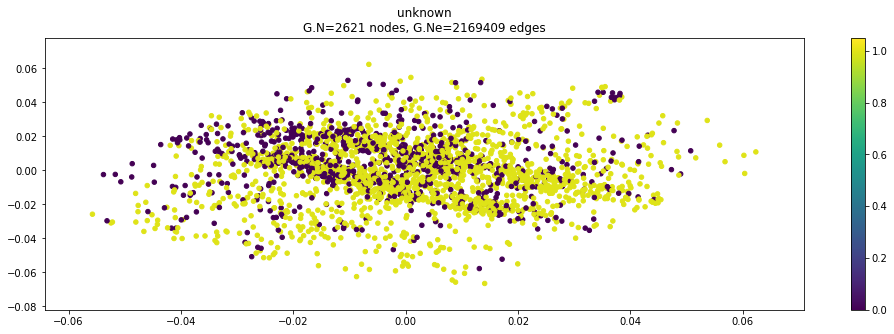

In [84]:
G.plot_signal(genres, vertex_size=20)

In [85]:
#G.plot_signal(G.U[:, 1], vertex_size=50)

#Note: The signal is equal to the coordinate along the defined eigenvector axis (1 or 2)

## (Tests) ##

In [86]:
dfTrainLabels = pd.read_csv('Saved_Datasets/Train.csv')
dfTestLabels = pd.read_csv('Saved_Datasets/Test.csv')

In [87]:
len(dfTrainLabels) + len(dfTestLabels)

2620

In [88]:
dfTrainLabels.iloc[-5:]

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,tagline,title,director_name,director_id,actor_names,actor_ids,ROI,Metacritic,success
1741,72113,25000000,Comedy|Drama,1692486,After 11-year-old Zachary Cowan strikes his cl...,Wild Bunch,2011-09-16,27603069,A new comedy of no manners,Carnage,Roman Polanski,41,"['Kate Winslet', 'Jodie Foster', 'Christoph Wa...","[131, 228, 936, 254, 4785]",0.104123,61,1
1742,64639,25000000,Drama|Thriller,999913,L.A. screenwriter David Sumner relocates with ...,Battleplan Productions,2011-09-16,10324441,Everyone Has A Breaking Point,Straw Dogs,Rod Lurie,210,"['James Marsden', 'Kate Bosworth', 'Alexander ...","[494, 310, 913, 2586, 2382]",-0.587022,45,0
1743,47760,8000000,Drama|Romance,1498569,"A powerful and emotional coming of age story, ...",Columbia Pictures,2011-09-16,163265,Who do you live for?,Restless,Gus Van Sant,91,"['Mia Wasikowska', 'Henry Hopper', 'Ryo Kase',...","[460, 1659, 2653, 3653, 4708]",-0.979592,87,0
1744,70868,24000000,Romance|Comedy,1742650,"A comedy centered on the life of Kate Reddy, a...",The Weinstein Company,2011-09-16,30551495,"If it were easy, men would do it too.",I Don't Know How She Does It,Douglas McGrath,459,"['Sarah Jessica Parker', 'Pierce Brosnan', 'Sa...","[230, 200, 2729, 3720]",0.272979,38,1
1745,59965,35000000,Thriller|Action|Mystery,1600195,A young man sets out to uncover the truth abou...,Lions Gate Films,2011-09-22,82087155,They stole his life. He's taking it back.,Abduction,John Singleton,67,"['Taylor Lautner', 'Lily Collins', 'Alfred Mol...","[535, 912, 1108, 1291, 1087]",1.345347,25,1


In [89]:
dfTestLabels.iloc[:5]

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,tagline,title,director_name,director_id,actor_names,actor_ids,ROI,Metacritic,success
0,60308,50000000,Drama,1210166,The story of Oakland Athletics general manager...,Columbia Pictures,2011-09-22,110206216,What are you really worth?,Moneyball,Bennett Miller,57,"['Brad Pitt', 'Jonah Hill', 'Philip Seymour Ho...","[88, 288, 57, 1798, 908]",1.204124,87,1
1,79120,8000,Drama|Romance,1714210,After a drunken house party with his straight ...,EM Media,2011-09-22,469947,A (sort of) love story between two guys over a...,Weekend,Andrew Haigh,1091,"['Tom Cullen', 'Chris New', 'Jonathan Race', '...","[861, 1764, 2751, 3749, 4805]",57.743375,81,1
2,62837,37000000,Drama|Family,1564349,A story centered on the friendship between a b...,Alcon Entertainment,2011-09-23,95404397,Inspired by the amazing true story of Winter.,Dolphin Tale,Charles Martin Smith,1033,"['Morgan Freeman', 'Ashley Judd', 'Harry Conni...","[132, 443, 1491, 2869, 756]",1.578497,64,1
3,45610,30000000,Action|Thriller|Crime,1586752,"The true story of Sam Childers, a former drug-...",Mpower Pictures,2011-09-23,2527904,Hope is the greatest weapon of all,Machine Gun Preacher,Marc Forster,103,"['Gerard Butler', 'Michelle Monaghan', 'Kathy ...","[119, 974, 2645, 3645, 4699]",-0.915737,43,0
4,49021,66000000,Action|Adventure|Thriller,1448755,"Based on a shocking true story, Killer Elite p...",Current Entertainment,2011-09-23,57777106,May the best man live.,Killer Elite,Gary McKendry,967,"['Jason Statham', 'Clive Owen', 'Robert De Nir...","[18, 222, 156, 2586, 1788]",-0.124589,44,0


In [90]:
#dfNewFeats = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [91]:
#len(dfNewFeats)

In [92]:
#dfNewFeats.head()